In [43]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
from torch.autograd import Variable
import os
from torch.utils.data import Dataset, DataLoader
import statistics
import csv
from sklearn.metrics import confusion_matrix

In [44]:
cuda_available = torch.cuda.is_available()
print(cuda_available)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

True


In [45]:
data_for_gene_function = torch.tensor((), dtype=torch.float64)

In [46]:
#load data channel = subseq
def load_file(file, flabel,subseq = 15, version = 2):
    
    global data_for_gene_function
    
    
    f = open(file, 'r')
    Lines = f.readlines()
    t = 1
    data = []
    for line in Lines:
        t += 1
        line = line.split()[0:75] #75=25*3

        data += line
    
    fl = open(flabel, 'r')
    label = fl.readlines()[0]
    #print (len(label))
    
    
    #data
    samples=len(label)
    data_len= samples * subseq * 75
    data = data[0:data_len]
    data = [float(i) for i in data] 
    data = np.array(data)
    data = data.reshape(samples,subseq,75)
    
    data_for_gene_function=data #provisoire
    
    if version == 2:
        data = np.delete(data,[0,2,3,4,5,7,8,10,11,12,14],1)
        

    #label
    label = [int(x) for x in (label)]     
    label=np.asarray(label)
    #print (data.shape, label.shape)
    
    f.close()

    return data,label

In [47]:
def load_dataset(data_path, flabel_path,subseq, version):
    data = []
    label = []
    i=0
    for filename in os.listdir(data_path):
        data1, label1 = load_file(os.path.join(data_path,filename),os.path.join(flabel_path,filename),subseq, version)
        data.append(torch.tensor(data1).float())
        label.append(torch.tensor(label1))
        i+=1
        
    data= torch.cat(data, 0)
    label= torch.cat(label, 0)
    print ('nb file = ', i)
    
    #print (data.shape)
    #print (label.shape)
    
    return data,label

In [48]:
class MyDataset(Dataset):
    def __init__(self, data_path, flabel_path, subseq, version):
        #data loading
        data, label = load_dataset(data_path, flabel_path, subseq, version)
        self.x = data
        self.y = label
        self.n_samples = data.shape[0]
        
        
    def __getitem__(self, index):
        #dataset[0]
        return self.x[index], self.y [index]
        
    def __len__(self):
        #len dataset
        return self.n_samples
        

In [47]:
#load train data
subseq = 15
version = 2
data_path= '/home/oussema/code/PKU-MMD/PKU_Skeleton_Renew/data/sub_train'
flabel_path='/home/oussema/code/st-gcn/pku/pku_action_detect/train'

datapku_train = MyDataset(data_path, flabel_path, subseq, version)
dataloader_train = DataLoader(dataset=datapku_train, batch_size = 256, drop_last=True)


nb file =  928


In [49]:
#load test data
subseq = 15
version = 2
data_path= '/home/oussema/code/PKU-MMD/PKU_Skeleton_Renew/data/sub_test'
flabel_path='/home/oussema/code/st-gcn/pku/pku_action_detect/test'
datapku_test = MyDataset(data_path, flabel_path, subseq, version )
dataloader_test = DataLoader(dataset=datapku_test, batch_size = 1, drop_last=True)

nb file =  130


In [50]:
#load exemple data
subseq = 15
version = 2
data_path= '/home/oussema/code/PKU-MMD/PKU_Skeleton_Renew/data/exemple'
flabel_path='/home/oussema/code/st-gcn/pku/pku_action_detect/test'

datapku_exemple = MyDataset(data_path, flabel_path, subseq, version)
dataloader_exemple = DataLoader(dataset=datapku_exemple, batch_size = 1, drop_last=True)

nb file =  1


In [8]:
#afficher data
dataiter = iter(dataloader_test)
data = dataiter.next()
x,y = data

In [64]:
print(x.shape)
len(datapku_test)

torch.Size([1, 4, 75])


40817

In [51]:
KERNEL_SIZE = 3
PAD = 1
LEARNING_RATE = 0.1
subseq = 4

#-> CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC ->

#conv1d input [batch_size, in_channels, len]
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            
            #nn.BatchNorm1d(subseq),
            
            # Layer 1: Convolution - ReLU - Max pooling - batch norm
            nn.Conv1d(in_channels=subseq, out_channels=64, kernel_size=KERNEL_SIZE, padding=PAD),
            #nn.BatchNorm1d(64),
            nn.ReLU(),
            #nn.Conv1d(in_channels=64, out_channels=64, kernel_size=KERNEL_SIZE, padding=PAD),
            #nn.BatchNorm1d(64),
            #nn.ReLU(),
            #nn.Dropout(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            
            # Layer 2: Convolution - ReLU - Max pooling
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=KERNEL_SIZE, padding=PAD),
            #nn.BatchNorm1d(128),
            nn.ReLU(),
            #nn.Conv1d(in_channels=128, out_channels=128, kernel_size=KERNEL_SIZE, padding=PAD),
            #nn.BatchNorm1d(128),
            #nn.ReLU(),
            #nn.Dropout(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            

            # Layer 3: Convolution - ReLU - Max pooling
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=KERNEL_SIZE, padding=PAD),
            #nn.BatchNorm1d(256),
            nn.ReLU(),
            #nn.Conv1d(in_channels=256, out_channels=256, kernel_size=KERNEL_SIZE, padding=PAD),
            #nn.BatchNorm1d(256),
            #nn.ReLU(),
            #nn.Dropout(),
            nn.MaxPool1d(kernel_size=2, stride=2)
            


        )
        # Layer 5-6-7: Fully connected linear layers
        self.fc1 = nn.Linear(256*9, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        
    def forward(self, x):
        temp = self.conv(x)
        temp = temp.view(-1,256*9)
        temp = self.fc1(temp)
        temp = self.fc2(temp)
        temp = self.fc3(temp)
        #temp = torch.softmax(temp, dim=0)
        return temp

In [52]:
cnn = Classifier()
if cuda_available:
    cnn = cnn.cuda()
    
optimizer = torch.optim.SGD(cnn.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.Adam(cnn.parameters())#,weight_decay=0.04

criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss() 

pytorch_total_params = sum(p.numel() for p in cnn.parameters())
print('Number of parameters in the model: %d' % pytorch_total_params)
print(cnn)

Number of parameters in the model: 1370178
Classifier(
  (conv): Sequential(
    (0): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [124]:
epochs = 99
for epoch in range (epochs):
    correct = 0
    train_losses = []
    
    cnn.train()
    for batch_idx, (data,label) in enumerate(dataloader_train):
        
        if cuda_available:
                data, label = data.cuda(), label.cuda()

        optimizer.zero_grad()
        output = cnn(data.float())
        loss = criterion (output, label)
        pred = output.data.max(1)[1]
        correct += pred.eq(label).sum().item()
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
    train_acc = 100*correct/len(datapku_train)
    print(epoch," : ")
    print("train acc: ",train_acc)
    print("train losses: ",statistics.mean(train_losses))
    
    if epoch%2 == 0:
        test()
        


0  : 
train acc:  77.41580893374638
train losses:  0.4947511018746542
test acc:  78.38645662346572
1  : 
train acc:  80.7384830618567
train losses:  0.44660596442710826
2  : 
train acc:  81.65750641217814
train losses:  0.4326617953720353
test acc:  78.68290173212142
3  : 
train acc:  82.23443589487358
train losses:  0.42447578488712423
4  : 
train acc:  82.59318477066054
train losses:  0.4178447266690967
test acc:  79.7167846730529
5  : 
train acc:  82.93927584024516
train losses:  0.412615075682007
6  : 
train acc:  83.10915692348689
train losses:  0.4080743301570822
test acc:  80.2435259818213
7  : 
train acc:  83.35631724459545
train losses:  0.4044608204488868
8  : 
train acc:  83.49788481396357
train losses:  0.4013576951551763
test acc:  80.28762525418331
9  : 
train acc:  83.59648246227641
train losses:  0.39959967019411485
10  : 
train acc:  83.60347756570401
train losses:  0.3988146046144767
test acc:  79.83438273268492
11  : 
train acc:  83.7203957229939
train losses:  0.396

96  : 
train acc:  85.23000566270278
train losses:  0.36399339995134
test acc:  81.80660019109685
97  : 
train acc:  85.2479930715166
train losses:  0.36401155022681775
98  : 
train acc:  85.23899936710968
train losses:  0.3639644612478722
test acc:  81.47095572923047


In [13]:
test()

test acc:  84.11446211137516


In [30]:
#we can save optimizer parameters
torch.save(cnn.state_dict(),'/home/oussema/code/st-gcn/pku/model/CNN-1D-V2-2cls-bn-drop')

In [53]:
cnn.load_state_dict(torch.load('/home/oussema/code/st-gcn/pku/model/CNN-1D-V2-2cls'))

<All keys matched successfully>

In [12]:
# run a test loop
def test():
    test_loss = 0
    correct = 0

    cnn.eval()
    with torch.no_grad():  
        for batch_idx, (data,label) in enumerate(dataloader_test):
            if cuda_available:
                    data, label = data.cuda(), label.cuda()
            net_out = cnn(data)
            # sum up batch loss
            test_loss += criterion(net_out, label).data
            pred = net_out.data.max(1)[1]  # get the index of the max log-probability
            correct += pred.eq(label.data).sum().item()
            #print(label)
            #print(pred)
            #print("***")
        
        test_acc = 100*correct/len(datapku_test)
        print ("test acc: ",test_acc)

# TEST

In [100]:
test_loss = 0
correct = 0

action_state = 0
action_start = 0
action_finish = 0
file_name = '/home/oussema/code/PKU-MMD/PKU_Skeleton_Renew/data/st-gcn data/skeleton/S001C001P001R001A00'
action_compteur = 0
last_label = 0

label_matrix = []
pred_matrix = []


cnn.eval()
with torch.no_grad():  
    for batch_idx, (data,label) in enumerate(dataloader_test):
        if cuda_available:
                    data, label = data.cuda(), label.cuda()
        net_out = cnn(data)
        # sum up batch loss
        test_loss += criterion(net_out, label).data
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
        #print(batch_idx)
        #print(label)
        #print(pred)
        #print("***")
        
        
        
        
        if pred == 1 and action_state == 0:
            action_state = 1
            action_start = batch_idx
            last_label = 1
        elif pred == 0 and action_state == 1 and last_label == 1:
            last_label = 0
            pred = torch.tensor([1]).cuda()
        elif pred == 0 and action_state == 1 and last_label == 0:            
            action_state = 0
            action_finish = batch_idx -1
            action_duration = action_finish-action_start+1
            action_compteur += 1 
            last_label = 0
            if  batch_idx == 115 :
                label_action = 2
            else:
                label_action = 1
            #gendata(file_name+str(int(label_action))+str(action_compteur), data_for_gene_function[action_start:action_finish+1],15*action_duration)
            #print(action_start*15,",",action_finish*15)
            
        label_matrix.append(label.cpu().numpy()[0])
        pred_matrix.append(pred.cpu().numpy()[0])
        
        
        correct += pred.eq(label.data).sum().item()
    print(action_compteur)
        
    test_acc = 100*correct/len(datapku_test)
    print ("test acc: ",test_acc)
    
    conf_matrix=confusion_matrix(label_matrix,pred_matrix,labels=[0, 1])
    print(conf_matrix)
    #label_matrix = [i for i in label_matrix if i != 0]
    #print(len(label_matrix))


3035
test acc:  84.58975426905457
[[16090  4021]
 [ 2269 18437]]


In [114]:
1348/15

89.86666666666666

# data generation 

In [291]:
#ADL class = 1
#fall class = 2

In [17]:
def gendata(outfile, data_in, nb_frame):
    
    #print(outfile)
    with open(outfile, 'w',newline="") as out:
        writer = csv.writer(out,delimiter=' ')
        
        writer.writerow([str(nb_frame)])
        data = data_in[0]
        for i in range (1,int(nb_frame/15)):
            data = np.concatenate((data, data_in[i]), axis = 0)


        #data = data.squeeze()
        row = [0]*3

        for i in range(0,len(data)):
            for j in range(0,len(data[0]),3):
                row[0] = str(data[i,j])
                row[1] = str(data[i,j+1])
                row[2] = str(data[i,j+2])
                writer.writerow(row)

    out.close()
    

In [28]:
gendata('/home/oussema/code/PKU-MMD/PKU_Skeleton_Renew/data/st-gcn data/skeleton/S001C001P001R001A002',data_for_gene_function[149:153],15*4)

/home/oussema/code/PKU-MMD/PKU_Skeleton_Renew/data/st-gcn data/skeleton/S001C001P001R001A002
(60, 75)


In [42]:
int(label)

1

# matrice de confusion

In [95]:
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[16090  4021]
 [ 2269 18437]]


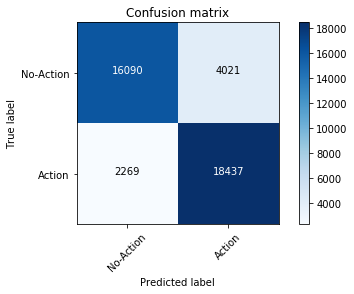

In [101]:
classes = [ "No-Action","Action"]
plot_confusion_matrix(conf_matrix,classes)